In [2]:
# import the necessary packages
import os, sys
import imutils
import cv2
import numpy as np
import random
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
from matplotlib import pyplot as plt

In [166]:
def imageToMap(image, hue = 0, brightness = 1, contrast = 0, sharpness = 0, invert = True):
    enc = ImageEnhance.Brightness(image)
    map_image = enc.enhance(0.1)

    enc = ImageEnhance.Contrast(image)
    map_image = enc.enhance(contrast)

    enc = ImageEnhance.Color(map_image)
    map_image = enc.enhance(hue)

    enc = ImageEnhance.Brightness(map_image)
    map_image = enc.enhance(brightness)

    enc = ImageEnhance.Sharpness(map_image)
    map_image = enc.enhance(sharpness)

    # Consider inverting when using light background
    if invert:
        map_image = ImageOps.invert(image)
        # Remove other layer except blue layer, skin tone if inverted turn blue
        data = map_image.getdata()
        layer = [(0, 0, d[2]) for d in data]
        map_image.putdata(layer)
    else:
        data = map_image.getdata()
        layer = [(d[2], 0, 0) for d in data]
        map_image.putdata(layer)

    return map_image

In [17]:
def removeBackground(image, map_image, retrieve_mask = False):
    stencil = np.zeros(map_image.shape[:-1]).astype(np.uint8)
    map_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)
    # convert to grayscale
    gray = cv2.cvtColor(map_image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (23, 23), 0)

    _, thresh = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations = 2)
    thresh = cv2.dilate(thresh, kernel, iterations = 3)
    thresh = cv2.GaussianBlur(thresh, (7, 7), 0)

    # find the contours from the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    cv2.fillPoly(stencil, cnts, 255)
    sel = stencil != 255
    map_image[sel] = [255, 255, 255]

    cv2.fillPoly(map_image, cnts, (0, 0, 0))

    image = cv2.bitwise_and(image, map_image)
    if retrieve_mask:
        map_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY)
        return map_image
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return image

In [4]:
def pilToCv(image):
    image = np.array(image)
    # Convert RGB to BGR
    return image[:, :, ::-1]

In [22]:
# Set dataset path location
BASE_PATH = os.path.join(os.getcwd(), '..', 'dataset')
PATH = os.path.join(BASE_PATH, 'hand-sign-bisindo-1')

In [160]:
# Set input and output location
LABEL = 'Z'
SAMPLE_PATH = os.path.join(PATH, 'original', LABEL)
OUT_PATH = os.path.join(PATH, 'anoted', LABEL)

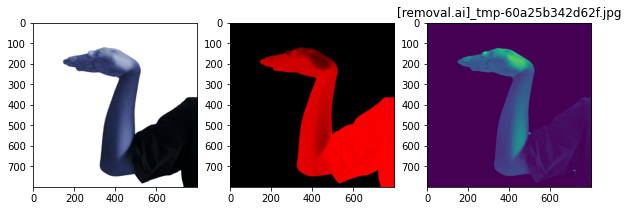

In [167]:
# See and test sample data image
files = os.listdir(SAMPLE_PATH)
files_num = len(files)
file_name = os.listdir(SAMPLE_PATH)[random.randint(0, files_num - 1)]
# file_name = 'WIN_20210513_16_44_49_Pro (2).jpg'
file_path = os.path.join(SAMPLE_PATH, file_name)

image = Image.open(file_path).convert('RGB')
image_map = imageToMap(image, hue = 3, brightness = 0, contrast = 0.1, sharpness = 0.1, invert = True)
image = pilToCv(image)
image_map = pilToCv(image_map)

res = removeBackground(image, image_map)

plt.figure(figsize = (10, 10))
plt.subplot(1, 3, 1).imshow(image)
plt.subplot(1, 3, 2).imshow(image_map)
plt.subplot(1, 3, 3).imshow(res)
plt.title(str(file_name))
plt.show()

# cv2.imwrite(os.path.join(OUT_PATH, str(file_name)), res)

In [168]:
# Enumerate every file in dir path
files = os.listdir(SAMPLE_PATH)

for idx, file in enumerate(files):
    image = Image.open(os.path.join(SAMPLE_PATH, str(file))).convert('RGB')

    image_map = imageToMap(image, hue = 9, brightness = 0.95, contrast = 0.2, sharpness = 0.2, invert = True)
    image = pilToCv(image)
    image_map = pilToCv(image_map)

    res = removeBackground(image, image_map)
    # Save extracted image
    cv2.imwrite(os.path.join(OUT_PATH, str(file)), res)
    
print('Done')

Done
